# Beijing Air Quality

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Andrea Dotti `andrea.dotti4@studio.unibo.it`

Giacomo Pierbattista `giacomo.pierbattista@studio.unibo.it`

Citazioni
 - Dataset originario:
  
  Beijing Multi-Site Air-Quality Data
 (https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data)
 
NOTA: Tale dataset consiste in un file .zip, che a sua volta contiene un altro file .zip. Quest'ultimo contiene i file .csv con i dati. 
 
Tale file .zip, per semplicità, è stato estratto manualmente dal file .zip originale, rinominato in "Datasets.zip" e caricato su GitHub per semplificare le operazioni di caricamento dei file.

## Parte 1 - Descrizione del problema e analisi esplorativa

Si vuole realizzare un modello che, utilizzando i dati climatici e sull'inquinamento registrati da alcuni sensori posti in alcuni distretti di Pechino/Beijing, sia in grado di prevedere con una buona accuratezza l'andamento della temperatura per monitorare come l'inquinamento influisce sul surriscaldamento globale e sul cambiamento climatico.

Vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [1]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Caricamento dei dati e preprocessing

In [2]:
file_zip_url = "https://raw.githubusercontent.com/jackprb/beijing-air-quality/master/datasets.zip"
file_zip_name = "datasets.zip"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [3]:
# short names for Beijing districts
dict_names = {"Ao" : "Aotizhongxin", 
      "Chang" : "Changping",
      "Ding" : "Dingling",
      "Dong" : "Dongsi",
      "Guan" : "Guanyuan",
      "Guc" : "Gucheng",
      "Hua" : "Huairou",
      "Nong" : "Nongzhanguan",
      "Shu" : "Shunyi",
      "Tia" : "Tiantan",
      "Wanl" : "Wanliu",
      "Wans" : "Wanshouxigong"
     }

data_all = []
for name in dict_names.values():
    with open("PRSA_Data_" + name + "_20130301-20170228.csv") as dataFile:
        data_all.append(pd.read_csv(dataFile, sep=","))

data_all = pd.concat(data_all)

Di seguito sono riportate le dimensioni in memoria e il tipo delle feature
che compongono i dati del dataset, comprensivo di _tutti_ i 12 file csv.

In [4]:
data_all.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 104.5 MB


Si nota che nel dataset originario, data e ora del rilevamento vengono memorizzate in 4 colonne distinte (year, month, day, hour).
Abbiamo deciso di unire tali colonne con un'unica nuova feature chiamata `date` che diventerà il nuovo indice.

Abbiamo rimosso la feature: 
- `No` (numero progressivo dei rilevamenti), in quanto non rilevante

Abbiamo anche convertito le variabili nominali della direzione del vento nei corrispettivi angoli, come sotto specificato. 

Inoltre abbiamo aggiunto la colonna `weekday` che indica il giorno della settimana (0 = Lunedì, ... , 6 = Domenica) come feature aggiuntiva.

In [5]:
data_all.insert(0, 'date','')
data_all['date'] = pd.to_datetime(data_all[['year', 'month', 'day', 'hour']])
data_all.set_index('date', inplace=True)
data_all.drop(['No'], axis=1, inplace=True)


# definisce mapping delle possibili direzioni del vento con numeri interi e lo applica al dataframe
wind_direction_mapping = { 'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
                          'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5 } 
data_all['wd'] = data_all['wd'].map(wind_direction_mapping)

data_all['weekday'] = data_all.index.dayofweek
data_all.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,weekday
date,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,337.5,4.4,Aotizhongxin,4
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,0.0,4.7,Aotizhongxin,4
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,337.5,5.6,Aotizhongxin,4
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,315.0,3.1,Aotizhongxin,4
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,0.0,2.0,Aotizhongxin,4
2013-03-01 05:00:00,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,0.0,3.7,Aotizhongxin,4
2013-03-01 06:00:00,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,22.5,2.5,Aotizhongxin,4
2013-03-01 07:00:00,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,337.5,3.8,Aotizhongxin,4
2013-03-01 08:00:00,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,337.5,4.1,Aotizhongxin,4


Ora andiamo ad analizzare il grafico heatmap delle relazioni e notiamo che:
 - i valori di `PM2.5`, `PM10`, `NO2` e `CO` sono molto correlati tra loro (coefficiente > 0.7)
 - essi sono correlati, in modo minore, anche con i valori di `SO2` (coefficiente > 0.5)
 - i valori della temperatura `TEMP` sono correlati con i valori di `O3` (coefficiente 0.6) e con `DEWP` (punto di rugiada)
 - la pressione atmosferica `PRES` è inversamente correlata con la temperatura `TEMP` e con il punto di rugiada `DEWP` (coefficiente -0.8).

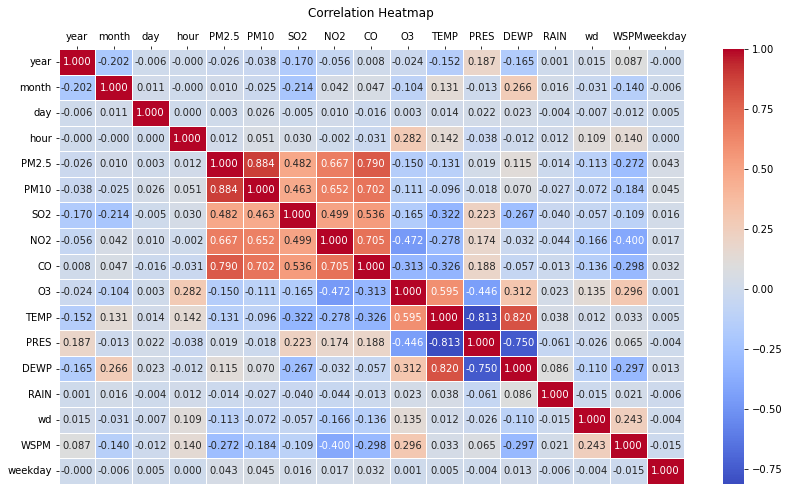

In [6]:
correlation_matrix = data_all.corr(method="pearson")
plt.figure(figsize=(14, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5) 
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Correlation Heatmap', pad=15) 
plt.show()

Dal grafico si evidenzia anche la **scarsa relazione** di alcune **feature** quindi abbiamo deciso di impostare usa soglia minima di relazione tra le feature per essere considerate utili nel modello(`threshold`).

In [7]:
correlation_matrix1 = correlation_matrix.where(correlation_matrix != 1, 0)
# Definiamo il valore minimo di correlazione per mantenere una feature
threshold = 0.3

true_columns = [col for col in correlation_matrix1.columns if abs(correlation_matrix1[col]).max() >= threshold]
false_columns = [col for col in correlation_matrix1.columns if abs(correlation_matrix1[col]).max() < threshold]

print("Feature significative:")
print(true_columns)

print("\nFeature che possono essere rimosse:")
print(false_columns)

Feature significative:
['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']

Feature che possono essere rimosse:
['year', 'month', 'day', 'hour', 'RAIN', 'wd', 'weekday']


A seguito dell'analisi andremo a rimuovere le feature: 
- `wd`
- `year`
- `month`
- `day`
- `hour`
- `weekday`
- `RAIN`.

In [8]:
Mb = 1_000_000
total_memory_before = (data_all.memory_usage(deep=True).sum())/Mb
data_all.drop(false_columns, axis=1, inplace=True)
total_memory_after = (data_all.memory_usage(deep=True).sum())/Mb
print('Memory usage before drop: ' , total_memory_before , ' Mb\nMemory usage after drop: ' , total_memory_after, ' Mb')

Memory usage before drop:  88.115832  Mb
Memory usage after drop:  64.552824  Mb


### Significato delle feature

Si riporta la descrizione delle feature dal dataset originale: 
https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

`date`: data e ora del rilevamento (indice del dataframe)

`PM2.5`: concentrazione di PM2.5 in ${\mu g}/{m^3}$

`PM10`: concentrazione di PM10 in ${\mu g}/{m^3}$

`SO2`: concentrazione di SO2 in ${\mu g}/{m^3}$

`NO2`: concentrazione di NO2 in ${\mu g}/{m^3}$

`CO`: concentrazione di CO in ${\mu g}/{m^3}$

`O3`: concentrazione di O3 in ${\mu g}/{m^3}$

`TEMP`: temperatura in gradi Celsius `°C`

`PRES`: pressione in `hPa`

`DEWP`: temperatura del punto di rugiata in gradi Celsius `°C`

`WSPM`: velocità del vento in `m/s`

`station`: nome della località dove sono stati rilevati i dati

### Esplorazione singole feature

E' possibile visualizzare media, deviazione standard e la distribuzione in termini di massimi, minimi e percentili per le colonne con valori numerici utilizzando il metodo `describe()`.

Con il metodo `.T` si ottiene il dataframe trasposto, in modo da avere il dataframe visibile per intero, senza la necessità delle barre di scorrimento orizzontali.

In [9]:
data_all.describe().T

,count,mean,std,min,25%,50%,75%,max
PM2.5,412029.0,79.793428,80.822391,2.0000,20.0,55.0,111.0,999.0
PM10,414319.0,104.602618,91.772426,2.0000,36.0,82.0,145.0,999.0
SO2,411747.0,15.830835,21.650603,0.2856,3.0,7.0,20.0,500.0
NO2,408652.0,50.638586,35.127912,1.0265,23.0,43.0,71.0,290.0
CO,400067.0,1230.766454,1160.182716,100.0000,500.0,900.0,1500.0,10000.0
O3,407491.0,57.372271,56.661607,0.2142,11.0,45.0,82.0,1071.0
TEMP,420370.0,13.538976,11.436139,-19.9000,3.1,14.5,23.3,41.6
PRES,420375.0,1010.746982,10.474055,982.4000,1002.3,1010.4,1019.0,1042.8
DEWP,420365.0,2.490822,13.793847,-43.4000,-8.9,3.1,15.1,29.1
WSPM,420450.0,1.729711,1.246386,0.0000,0.9,1.4,2.2,13.2


Con i metodi `isnull().sum(0)` si contano i valori mancanti nel dataset per righe.

Tale risultato viene poi ordinato in senso decrescente per visualizzare quali features hanno più dati mancanti.

In [10]:
data_missing_general = data_all.isnull().sum(0).sort_values(ascending=False)
data_missing_general

CO         20701
O3         13277
NO2        12116
SO2         9021
PM2.5       8739
PM10        6449
DEWP         403
TEMP         398
PRES         393
WSPM         318
station        0
dtype: int64

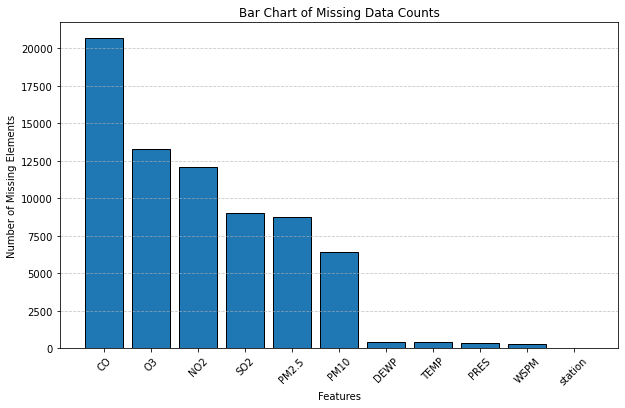

In [11]:
plt.figure(figsize=(10, 6)) 
plt.bar(data_missing_general.index, data_missing_general, edgecolor='k') 
plt.xlabel('Features'); plt.ylabel('Number of Missing Elements') 
plt.title('Bar Chart of Missing Data Counts') 
plt.xticks(rotation=45) # ruota etichette di asse x per leggibilità maggiore
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

Si osserva che le prime 6 features con più dati mancanti sono:
 1. CO
 2. O3
 3. NO2
 4. SO2
 5. PM2.5
 6. PM10
 
Notare che le PM2.5 e le PM10 sono comunemente note come, rispettivamente, "polveri sottili" e "particolato" e
costituiscono i principali inquinanti nelle aree urbane.

Il grafico seguente mostra l'andamento medio delle temperature durante il periodo di rilevamento. 

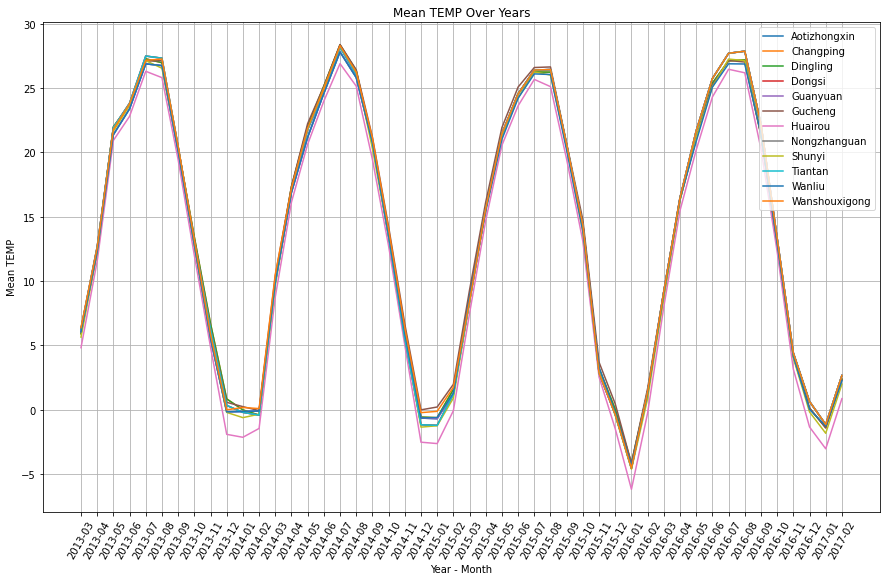

In [12]:
def plotMeanFeatureByDate(feature_name, df_name):
    # Group the data by cities and year, and calculate mean 'feature_name' for each group
    grouped = df_name.groupby(['station', df_name.index.strftime("%Y-%m")])[feature_name].mean().reset_index()

    # Create a Matplotlib figure and axis
    plt.figure(figsize=(15, 9))

    # Plot mean 'feature_name' values over years for each city
    for city, group in grouped.groupby('station'):
        plt.plot(group['date'], group[feature_name], label=city)

    plt.xticks(grouped['date'].unique())
    # Customize the plot
    plt.title('Mean ' + feature_name + ' Over Years')
    plt.xlabel('Year - Month')
    plt.ylabel('Mean ' + feature_name)
    plt.xticks(rotation=60) # ruota etichette di asse x per leggibilità maggiore
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1)) 
    plt.grid(True)
    
    # Display the plot
    plt.show()   

plotMeanFeatureByDate("TEMP", data_all);

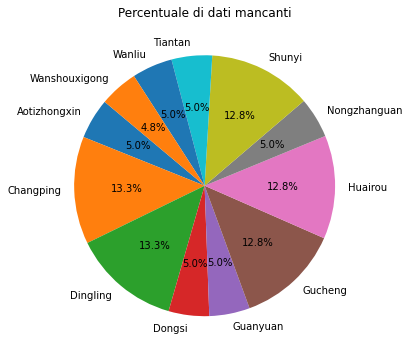

station
Wanshouxigong    19
Aotizhongxin     20
Dongsi           20
Guanyuan         20
Nongzhanguan     20
Tiantan          20
Wanliu           20
Gucheng          51
Huairou          51
Shunyi           51
Changping        53
Dingling         53
Name: TEMP, dtype: int64

In [13]:
data_missing = data_all.groupby('station')['TEMP'].apply(lambda x: x.isnull().sum())
# mostra numero totale di dati mancanti per ogni feature e per ogni zona di Beijing

plt.figure(figsize=(6, 6)) 
plt.pie(data_missing, labels=data_all['station'].unique(), autopct='%1.1f%%', startangle=140) 
plt.title('Percentuale di dati mancanti') 
plt.show()

data_missing.sort_values()

Di seguito andremo a riempire i **dati mancanti (Nan)** con il metodo `ffill`, sostituendoli con il valore dell'ultima rilevazione non nulla, anzichè la sostituzione con il valore medio, in quanto ci aspettiamo che tale sostituzione funzioni molto bene su questa serie temporale di rilevazioni.

In [14]:
data_ffilled = data_all.fillna(method="ffill")
data_ffilled.isnull().sum()

PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
WSPM       0
station    0
dtype: int64

Definiamo il dataset `data_wan` riferito alla località Wanshouxigong, poiché è la zona con meno valori mancanti.

In [15]:
data_wan = data_ffilled.loc[data_ffilled['station'] == 'Wanshouxigong', data_ffilled.columns != 'station']
data_wan

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM
date,,,,,,,,,,
2013-03-01 00:00:00,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,2.0
2013-03-01 01:00:00,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,4.4
2013-03-01 02:00:00,8.0,8.0,7.0,16.0,200.0,59.0,-0.6,1022.6,-19.7,4.7
2013-03-01 03:00:00,8.0,8.0,3.0,16.0,200.0,59.0,-0.7,1023.5,-20.9,2.6
2013-03-01 04:00:00,8.0,8.0,3.0,16.0,300.0,36.0,-0.9,1024.1,-21.7,2.5
...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,2.4
2017-02-28 20:00:00,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.9
2017-02-28 21:00:00,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,1.1


Poiché le temperature in gradi Celsius (°C) oscillano tra valori positivi e negativi, con possibilità di assumere il valore 0, abbiamo notato che ciò potrebbe causare dei problemi nel calcolo dell'errore relativo, in quanto si avrebbe una divisione con denominatore zero.
Di conseguenza, abbiamo deciso di convertire le temperature da gradi Celsius in gradi Kelvin (K), secondo la relazione

$T_K = T_C + 273.15 K$

in cui $T_K$ è la temperatura in gradi Kelvin (K)
e $T_C$ è la temperatura in gradi Celsius (°C)

In [16]:
data_wan['TEMP'] = data_wan['TEMP'].apply(lambda x: x + 273.15)

Al dataset `data_wan` rimuoviamo la feature da predire, cioè `TEMP` e otteniamo le variabili X e y che contengono, rispettivamente, i valori di tutte le feature indipendenti e i valori della feature da predire (dipendente).

Successivamente, con il metodo `train_test_split` dividiamo il contenuto delle variabili X e y in modo random tra il training e il validation set.

In [17]:
y = data_wan['TEMP']
X = data_wan.drop(['TEMP'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=42)

Valutiamo quanto sono correlati i valori delle features tra loro, con la funzione `corr` di Pandas.

Dal grafico heatmap sotto si nota che:
 - i valori di `PM2.5`, `PM10`, `NO2` e `CO` sono molto correlati tra loro (coefficiente > 0.7)
 - essi sono correlati, in modo minore, anche con i valori di `SO2` (coefficiente > 0.5)
 - i valori della temperatura `TEMP` sono correlati con i valori di `O3` (coefficiente 0.6) e con `DEWP` (punto di rugiada)
 - la pressione atmosferica `PRES` è inversamente correlata con la temperatura `TEMP` e con il punto di rugiada `DEWP` (coefficiente -0.8).

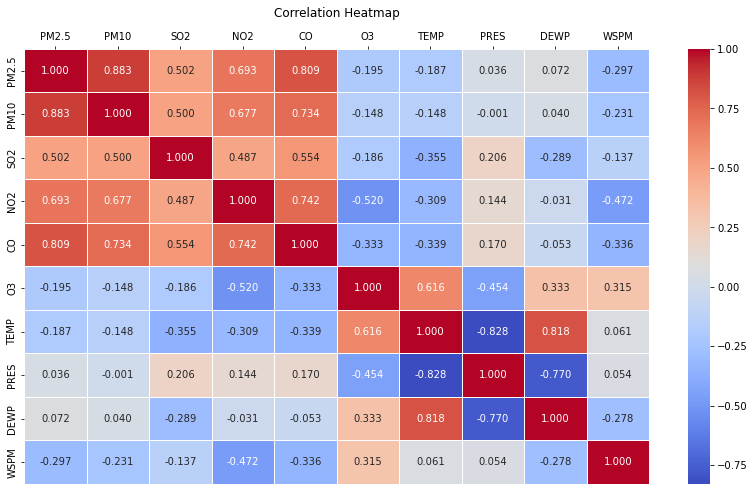

In [18]:
correlation_matrix = data_wan.corr(method="pearson")
plt.figure(figsize=(14, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5) 
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Correlation Heatmap', pad=15) 
plt.show()

Definiamo le funzioni per calcolare l'errore relativo e per visualizzare le valutazioni di un modello.

In [19]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval_all(X_train, y_train, X_val, y_val, model):
    print(f"   ----------Training----------")
    print_eval(X_train, y_train, model)
    print(f"\n   --------Validation----------")
    print_eval(X_val, y_val, model)
    
def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")
    
def plot_model_on_data(X, y, model=None, label_x = "label X", label_y = "label Y"):
    plt.figure(figsize=(10, 7))
    plt.scatter(X.index, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = X.index #np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(X)
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel(label_x); plt.ylabel(label_y)
    
def print_coeff_intercept(X, model):
    print(f"\nCoefficient(s):\n{ pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)}")
    print(f"\nIntercept: {model.intercept_}")
    
def plotMeanFeatureByDateAndCity(feature_name, df_name, city_name, model_df = None):
    # Group the data by cities and year, and calculate mean 'feature_name' for each group
    grouped = df_name.groupby(df_name.index.strftime("%Y-%m"))[feature_name].mean()
    grouped = pd.DataFrame(grouped, index=grouped.index)
    
    # Create a Matplotlib figure and axis
    plt.figure(figsize=(15, 9))

    # Plot mean 'feature_name' values over years for each city
    plt.plot(grouped.index, grouped['TEMP'], color='blue', label=city_name)
    if model_df is not None:
        grouped = model_df.groupby(model_df.index.strftime("%Y-%m"))[feature_name].mean()
        grouped = pd.DataFrame(grouped, index=grouped.index)
        plt.plot(grouped.index, grouped['TEMP'], color='red', label="Model prediction")
    
    # Customize the plot
    plt.title('Mean ' + feature_name + ' Over Years')
    plt.xlabel('Year - Month')
    plt.ylabel('Mean ' + feature_name)
    plt.xticks(rotation=60) # ruota etichette di asse x per leggibilità maggiore
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1)) 
    plt.grid(True)
    
    # Display the plot
    plt.show()   
    
def getPredictions(X, model):
    preds = model.predict(X) 
    results = pd.DataFrame(preds, index=X.index, columns=["TEMP"]) 
    return results

Creiamo un modello di regressione lineare semplice e lo addestriamo con il dataset di training `X_train` e `y_train`, ottenuto dalla divisione **random** dei dati con la funzione `train_test_split` di Scikit Learn.

Per avere una stima di come il modello rappresenta i dati, abbiamo provato a raggruppare la media mensile dei dati predetti (come nel grafico iniziale in cui viene mostrato l'andamento mensile medio delle temperature in tutte le zone di Pechino) e la media mensile dei dati noti, ottenendo il seguente grafico.

   ----------Training----------
   Mean squared error: 15.262
       Relative error: 1.07245%
R-squared coefficient: 0.88243

   --------Validation----------
   Mean squared error: 15.127
       Relative error: 1.06643%
R-squared coefficient: 0.88299

Coefficient(s):
WSPM     1.184982
DEWP     0.462048
O3       0.050362
NO2      0.032145
PM10     0.003147
SO2     -0.000840
CO      -0.001318
PM2.5   -0.014030
PRES    -0.300454
dtype: float64

Intercept: 585.5958727745672


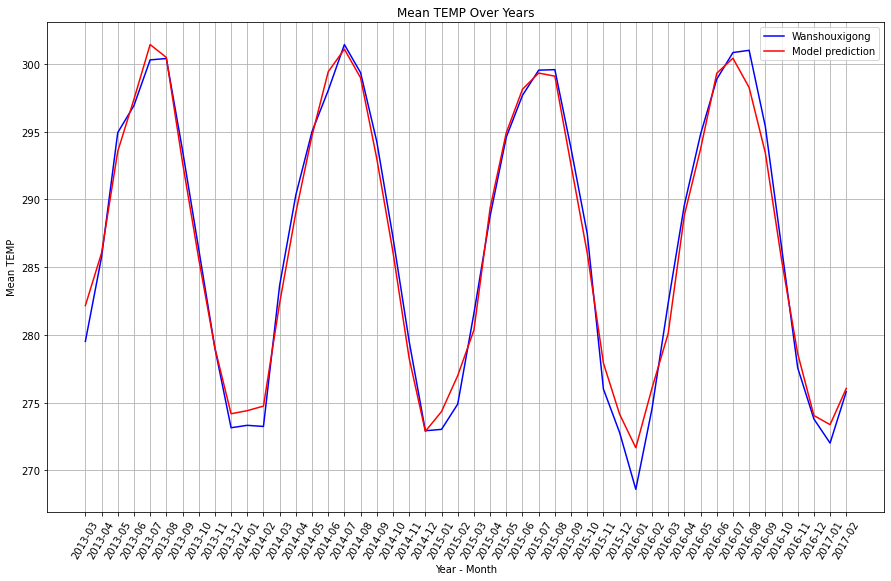

In [20]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print_eval_all(X_train, y_train, X_val, y_val, lrm)
print_coeff_intercept(X_train, lrm)

# otteniamo le predizioni del modello, le inseriamo in un dataframe e 
# disegnamo il grafico delle predizioni sovrapposto al grafico dei dati noti
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, lrm)) 

Abbiamo ottenuto risultati molto accurati, presumibilmente grazie al numero di features che rappresentano in modo significativo i dati, nonostante il modello utilizzato sia di regressione lineare semplice.

Controllando i coefficienti assegnati alle feature dal modello, si nota che, inaspettatamente, è stata data molta importanza alla velocità del vento (feature `WSPM`), mentre, come previsto, è stata data una certa importanza alla feature `DEWP`, indicante il punto di rugiada.



Ora creiamo un altro modello di **regressione lineare semplice** in cui utilizziamo la **suddivisione temporale tra training e validation set**.

In [21]:
is_trainDate = (data_wan.index.year < 2015) | ((data_wan.index.year == 2015) & (data_wan.index.month <= 2))
X_train_date = data_wan.loc[is_trainDate, data_wan.columns != 'TEMP']
y_train_date = data_wan.loc[is_trainDate, "TEMP"]
X_val_date = data_wan.loc[~is_trainDate, data_wan.columns != 'TEMP']
y_val_date = data_wan.loc[~is_trainDate, "TEMP"]

   ----------Training----------
   Mean squared error: 15.894
       Relative error: 1.09545%
R-squared coefficient: 0.87256

   --------Validation----------
   Mean squared error: 15.105
       Relative error: 1.05381%
R-squared coefficient: 0.88775

Coefficient(s):
WSPM     1.184982
DEWP     0.462048
O3       0.050362
NO2      0.032145
PM10     0.003147
SO2     -0.000840
CO      -0.001318
PM2.5   -0.014030
PRES    -0.300454
dtype: float64

Intercept: 585.5958727745672


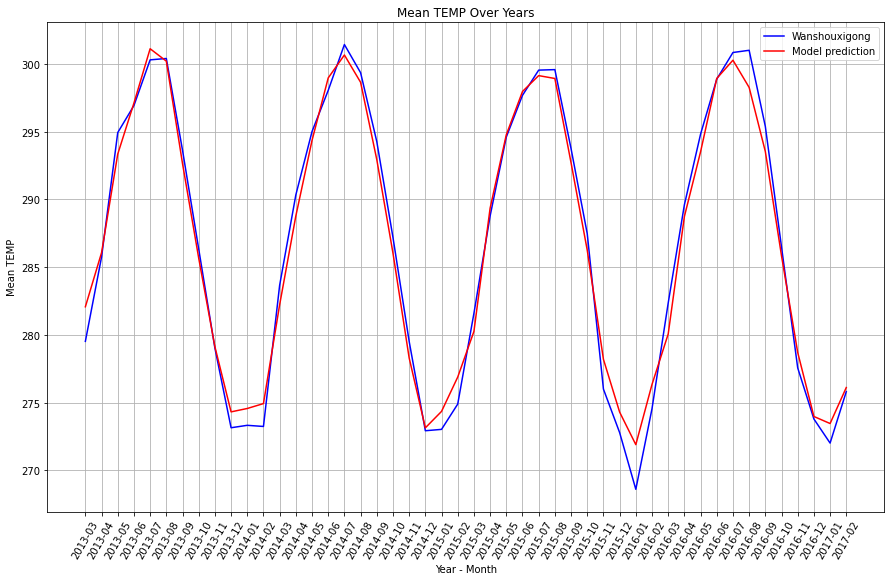

In [22]:
lrm2 = LinearRegression()
lrm2.fit(X_train_date, y_train_date)
print_eval_all(X_train_date, y_train_date, X_val_date, y_val_date, lrm2)
print_coeff_intercept(X_train, lrm)

# otteniamo le predizioni del modello, le inseriamo in un dataframe e 
# disegnamo il grafico delle predizioni sovrapposto al grafico dei dati noti
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, lrm2))

Si può notare che, anche in questo caso, l'accuratezza di quest'ultimo modello è relativamente alta ed è molto simile al risultato ottenuto dalla divisione random del dataset attraverso `train_test_split` di Scikit Learn.



Ora proviamo a creare un nuovo modello di regressione lineare, utilizzando le `Pipeline`, in cui applichiamo anche la standardizzazione delle feature con lo `StandardScaler()`.
Prima utilizziamo il dataset **diviso in modo casuale** (`X_train` e `y_train`).

   ----------Training----------
   Mean squared error: 15.262
       Relative error: 1.07245%
R-squared coefficient: 0.88243

   --------Validation----------
   Mean squared error: 15.127
       Relative error: 1.06643%
R-squared coefficient: 0.88299


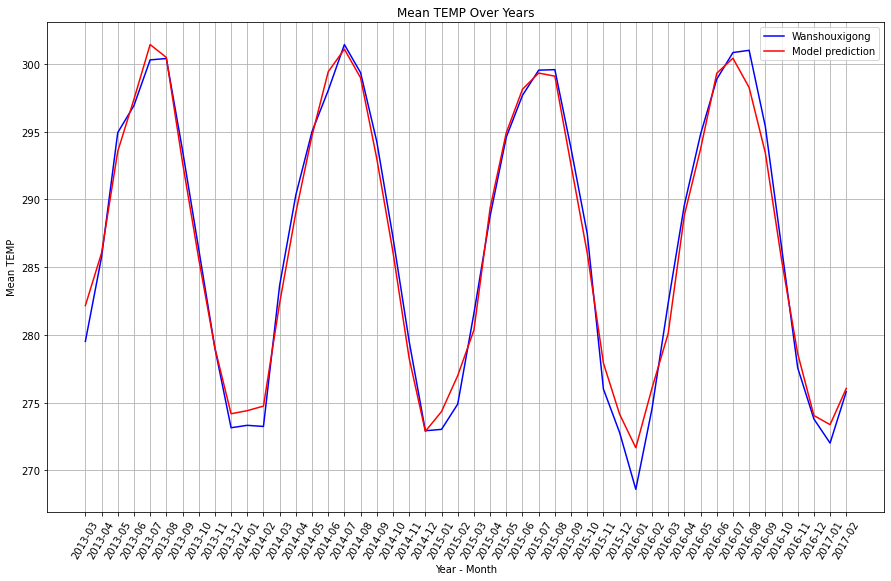

In [23]:
model1a = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
model1a.fit(X_train, y_train)
print_eval_all(X_train, y_train, X_val, y_val, model1a)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, model1a))

Ora utilizziamo il **dataset diviso temporalmente**.

   ----------Training----------
   Mean squared error: 15.894
       Relative error: 1.09545%
R-squared coefficient: 0.87256

   --------Validation----------
   Mean squared error: 15.105
       Relative error: 1.05381%
R-squared coefficient: 0.88775


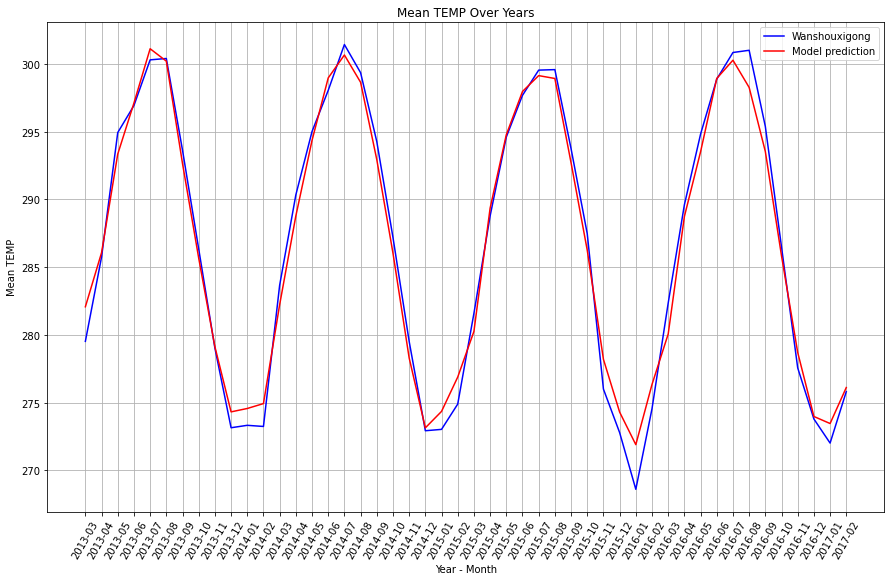

In [24]:
model1b = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
model1b.fit(X_train_date, y_train_date)
print_eval_all(X_train_date, y_train_date, X_val_date, y_val_date, model1b)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, model1b))

Anche in questo caso, i coefficienti $R^2$ rimangono attorno a 0.88, mentre gli errori relativi e i MSE rimangono ancora relativamente bassi.

Proviamo ad aumentare l'accuratezza introducendo le `PolynomialFeatures`, utilizzando la `GridSearchCV` per trovare il valore ottimale degli iperparametri, utilizzando il **dataset con dati divisi in modo random dal KFold**.

In [26]:
kf = KFold(5, shuffle=True, random_state=42)

In [27]:
%%time
model2a = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
grid = {
    "poly__degree": [2,3,4]
}
gs = GridSearchCV(model2a, grid, cv=kf)
gs.fit(X_train, y_train)
print("best params:", gs.best_params_, "\n")
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

best params: {'poly__degree': 2} 

CPU times: total: 30.2 s
Wall time: 9.05 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069561,0.005635,0.006575,0.002237,2,{'poly__degree': 2},0.906292,0.909472,0.910495,0.912964,0.914260,0.910697,0.002785,1
1,0.306356,0.018023,0.017691,0.002334,3,{'poly__degree': 3},0.917054,0.851433,0.919280,0.923440,0.922541,0.906750,0.027753,2
2,1.332104,0.080785,0.059572,0.009851,4,{'poly__degree': 4},0.887549,0.495467,0.863145,0.927831,0.918367,0.818472,0.163118,3


Si nota che si hanno risultati migliori con polinomi di grado 2.

Ora verifichiamo i risultati sui training e validation set separatamente.

   ----------Training----------
   Mean squared error: 11.497
       Relative error: 0.90599%
R-squared coefficient: 0.91143

   --------Validation----------
   Mean squared error: 11.354
       Relative error: 0.90126%
R-squared coefficient: 0.91217


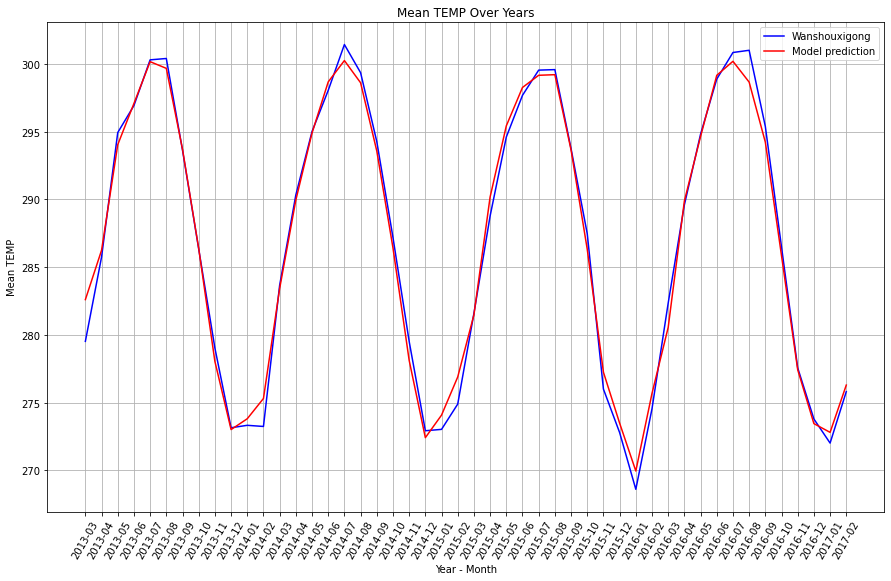

In [29]:
print_eval_all(X_train, y_train, X_val, y_val, gs.best_estimator_)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs.best_estimator_))

Notiamo che l'accuratezza indicata dal coefficiente $R^2$ è aumentata rispetto ai modelli di regressione lineare semplice.

Ora creiamo un `TimeSeriesSplit` con 5 split e addestriamo un nuovo modello che usa tale `TimeSeriesSplit` come metodo di cross validation, utilizzando i dati divisi temporalmente come dataset di training.

In [30]:
%%time
tss = TimeSeriesSplit(5)

model2a = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
grid = {
    "poly__degree": [2,3,4]
}
gs2 = GridSearchCV(model2a, grid, cv=tss)
gs2.fit(X_train_date, y_train_date)
print("best params:", gs2.best_params_, "\n")
pd.DataFrame(gs2.cv_results_).sort_values("mean_test_score", ascending=False)

best params: {'poly__degree': 2} 

CPU times: total: 16.5 s
Wall time: 4.57 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028307,0.009531,0.004783,0.001321,2,{'poly__degree': 2},0.734919,0.096958,0.762854,0.740578,0.460721,0.559206,0.256365,1
1,0.156080,0.097313,0.011359,0.002150,3,{'poly__degree': 3},0.449408,-2.597733,0.730572,0.754020,0.341426,-0.064461,1.276578,2
2,0.664763,0.237346,0.036683,0.006948,4,{'poly__degree': 4},-3.010204,-44.335588,0.674633,0.679972,-0.222341,-9.242706,17.598492,3


   ----------Training----------
   Mean squared error: 12.415
       Relative error: 0.94917%
R-squared coefficient: 0.90045

   --------Validation----------
   Mean squared error: 11.645
       Relative error: 0.91823%
R-squared coefficient: 0.91346


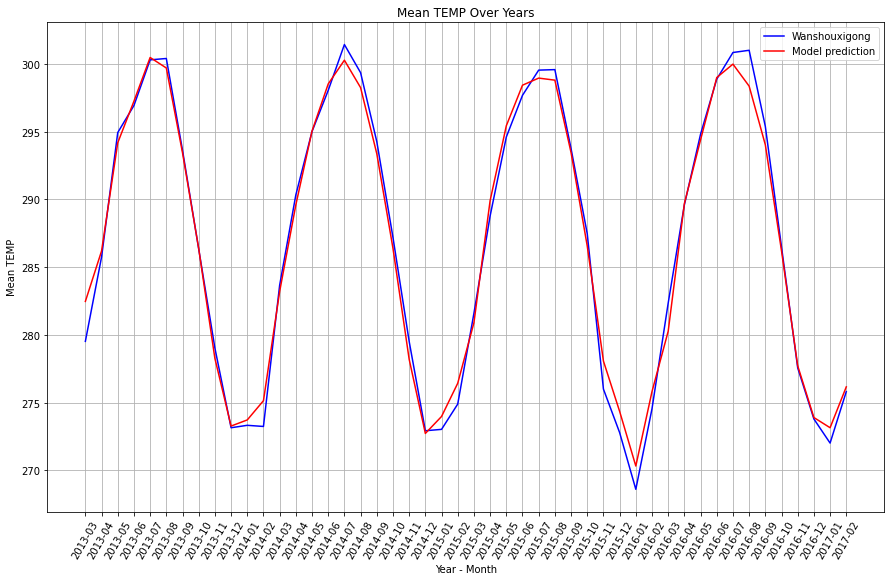

In [32]:
print_eval_all(X_train_date, y_train_date, X_val_date, y_val_date, gs2.best_estimator_)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs2.best_estimator_))

Dopo questi test, diversamente dalle nostre aspettative, abbiamo notato che dividendo il dataset in modo _random_ con KFold, si ottengono comunque risultati accurati e a volte anche leggermente migliori rispetto alla divisione _temporale_ del dataset.

A seguito di queste valutazioni, abbiamo deciso di addestrare i prossimi modelli con la divisione random utilizzando KFold.

In [33]:
%%time
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Ridge(alpha=10))
])
grid = {
    "poly__degree": [2, 3, 4, 5],
    "regr__alpha": [0.01, 0.1, 1, 10],
}
gs3 = GridSearchCV(model, grid, cv=kf)
gs3.fit(X_train, y_train);
gs3.best_params_

CPU times: total: 3min 9s
Wall time: 1min 7s


{'poly__degree': 4, 'regr__alpha': 1}

   ----------Training----------
   Mean squared error: 9.2741
       Relative error: 0.80688%
R-squared coefficient: 0.92855

   --------Validation----------
   Mean squared error: 11.329
       Relative error: 0.82949%
R-squared coefficient: 0.91237


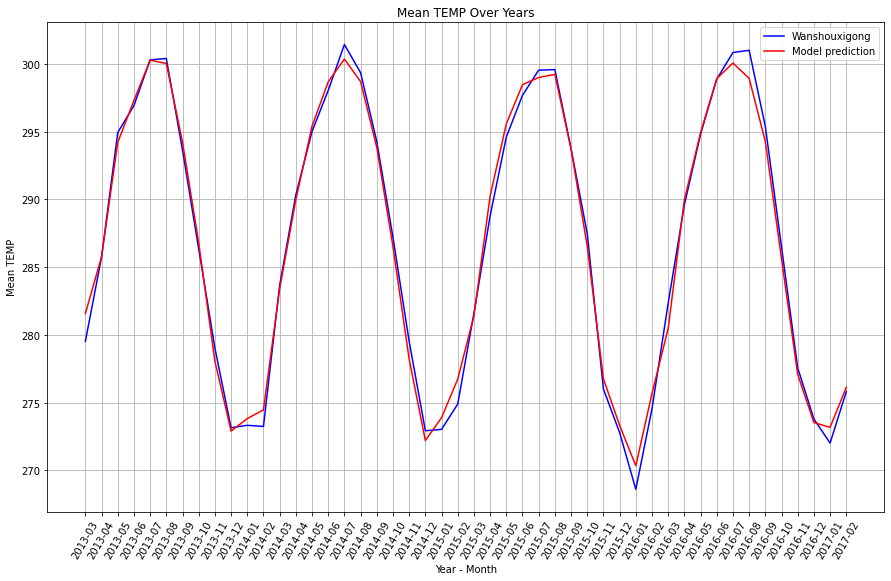

In [34]:
print_eval_all(X_train, y_train, X_val, y_val, gs3.best_estimator_)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs3.best_estimator_))